In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

%load_ext autoreload
%autoreload 2

os.chdir('drive/MyDrive/PR202010770/Lab02')

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt

## 1. 히스토그램 평활화

In [ ]:
img = cv2.imread("img/lab02_zebra.jpg", cv2.IMREAD_GRAYSCALE)
print(img.shape)

(342, 392)


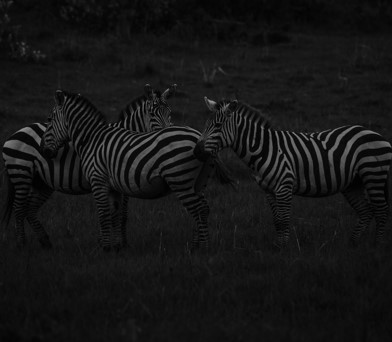

In [ ]:
cv2_imshow(img)

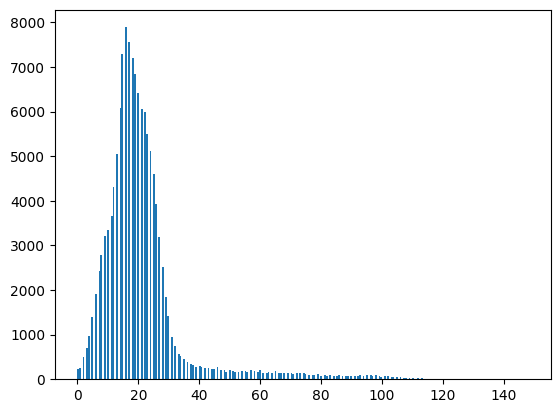

In [ ]:
plt.hist(img.flatten(), bins=256);

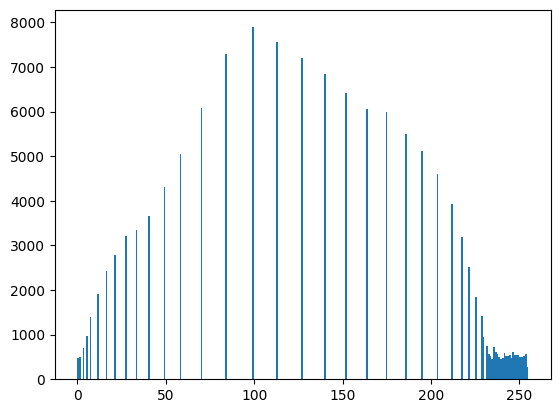

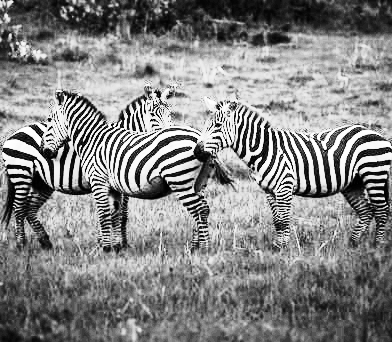

In [ ]:
imgEqualize = cv2.equalizeHist(img)
plt.hist(imgEqualize.flatten(), bins=256);
plt.show();
cv2_imshow(imgEqualize)

## 2. 히스토그램 역투영

In [ ]:
targetimg = cv2.imread("img/lab02_person.jpg")
modelimg = cv2.imread("img/lab02_modelpatch.jpg")

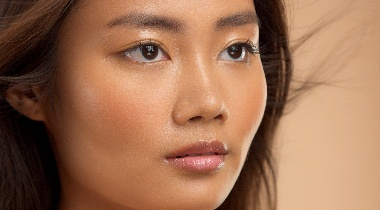

In [ ]:
cv2_imshow(targetimg)

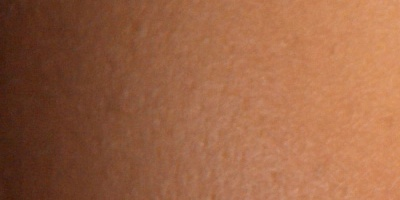

In [ ]:
cv2_imshow(modelimg)

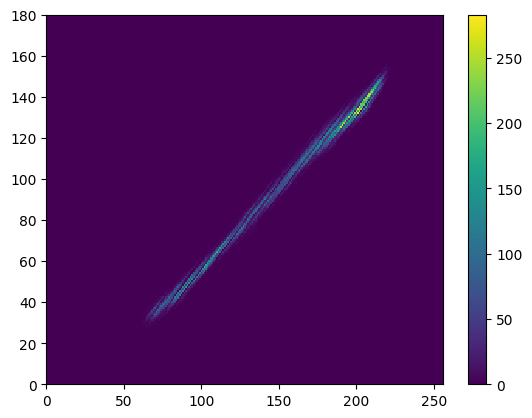

In [ ]:
## BGR 채널에서 G, R 사용
modelhist = cv2.calcHist([modelimg], [1,2], None, [180, 256], [0,180,0,256])
plt.pcolor(modelhist)
plt.colorbar()
plt.show()

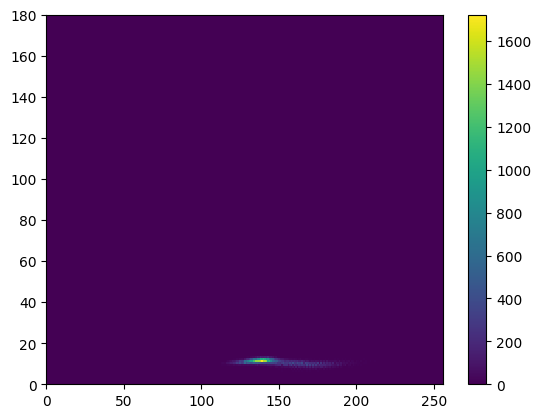

In [ ]:
## HSV 채널에서 H, S 사용
'''
이미지 modelimg를 HSV 채널로 변경하고
modelhist_hsv 에 H와 S 채널 히스토그램 만들기

'''
# 이미지를 HSV 색공간으로 변환
modelimg_hsv = cv2.cvtColor(modelimg, cv2.COLOR_BGR2HSV)

# H와 S 채널의 히스토그램 계산
modelhist_hsv = cv2.calcHist([modelimg_hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])

plt.pcolor(modelhist_hsv)
plt.colorbar()
plt.show()

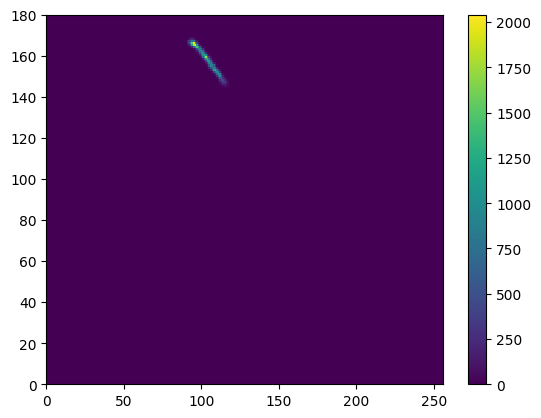

In [ ]:
## YCbCr 채널에서 Cb, Cr 사용
'''
이미지 modelimg를 YCbCr 채널로 변경하고
modelhist_YCrCb 에 Cb와 Cr 채널 히스토그램 만들기

'''
# 이미지를 YCbCr 채널로 변환
modelimg_YCrCb = cv2.cvtColor(modelimg, cv2.COLOR_BGR2YCrCb)

# Cb와 Cr 채널의 히스토그램 계산
modelhist_YCrCb = cv2.calcHist([modelimg_YCrCb], [1, 2], None, [180, 256], [0, 180, 0, 256])

plt.pcolor(modelhist_YCrCb)
plt.colorbar()
plt.show()

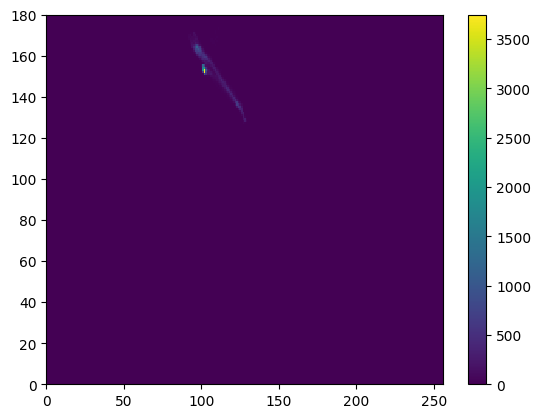

In [ ]:
## Target 이미지도 YCrCb 채널로 변경
'''
이미지 targetimg를 YCrCb 채널로 변경하고
targethist_YCrCb 에 H와 S 채널 히스토그램 만들기

'''
# 이미지를 YCrCb 색공간으로 변환
targetimg_YCrCb = cv2.cvtColor(targetimg, cv2.COLOR_BGR2YCrCb)

# H와 S 채널의 히스토그램 계산
targethist_YCrCb = cv2.calcHist([targetimg_YCrCb], [1, 2], None, [180, 256], [0, 180, 0, 256])

plt.pcolor(targethist_YCrCb)
plt.colorbar()
plt.show()

In [ ]:
print("Max value of Model hist {}".format(modelhist_YCrCb.max()))
print("Max value of Target hist {}".format(targethist_YCrCb.max()))

## Model과 target 이미지의 histogram 정규화
modelhist_YCrCb = modelhist_YCrCb/modelimg.size
targethist_YCrCb = targethist_YCrCb/targetimg.size

## 최대 값이 1보다 작음
print("Max value of Model hist {}".format(modelhist_YCrCb.max()))
print("Max value of Target hist {}".format(targethist_YCrCb.max()))

Max value of Model hist 2041.0
Max value of Target hist 3747.0
Max value of Model hist 0.008504166666666667
Max value of Target hist 0.015651629072681705


In [ ]:
## 비율 히스토그램 생성
hist_r = modelhist_YCrCb/ (targethist_YCrCb + 1e-7)0
hist_r = np.minimum(hist_r, 1.0)

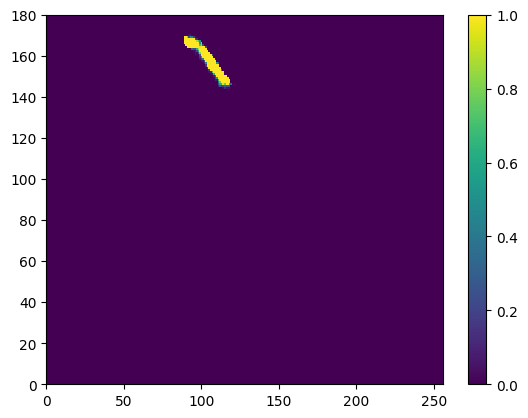

In [ ]:
plt.pcolor(hist_r)
plt.colorbar()
plt.show()

In [ ]:
hist_r.shape

(180, 256)

In [ ]:
## 출력 이미지 저장을 위한 배열 생성
height, width = targetimg.shape[0], targetimg.shape[1]
output = np.zeros_like(targetimg, dtype='float32')

In [ ]:
for i in range(height):
  for j in range(width):
    '''
    비율 히스토그램을 통해
    각 pixel에 대한 confidence 구하기

    '''
    confidence = hist_r[targetimg_YCrCb[i,j,1], targetimg_YCrCb[i,j,2]]
    output[i,j] = confidence

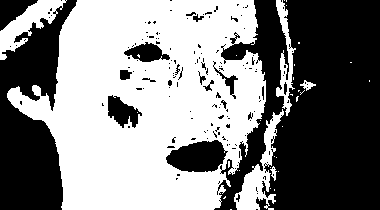

In [ ]:
ret, masked = cv2.threshold(output, 0.02, 255, cv2.THRESH_BINARY)
cv2_imshow(masked)

# 3. 컨볼루션 필터 학습

In [ ]:
import tensorflow as tf

# MNIST 데이터셋 로드
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0  # 이미지 정규화
X_train = np.expand_dims(X_train, axis=-1)    # 채널 차원 추가 (64, 64, 1)

# 학습에 사용할 데이터 크기 제한
X_train = X_train[:1000]  # 예제에서는 1000개만 사용

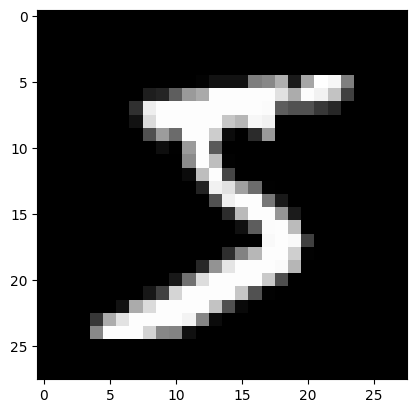

In [ ]:
'''
X_train 데이터 시각화

'''
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
# 필터(커널) 생성: 3x3 필터
''' 사용할 필터 사전에 입력하기 '''
## 4방향 라플라시안 필터 사용
true_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
true_kernel = true_kernel.reshape((3, 3, 1, 1))  # (height, width, input_channels, output_channels)

In [ ]:
# 필터를 적용하여 출력 이미지 (Y) 생성
Y_train = tf.nn.conv2d(X_train, true_kernel, strides=1, padding='SAME').numpy()

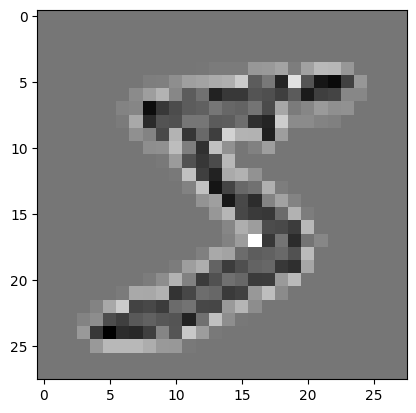

In [ ]:
'''
Y_train 데이터 시각화

'''
plt.imshow(Y_train[0].reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
# CNN 모델 정의: 필터 크기 3x3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1))
])

# 모델 컴파일: 손실 함수는 MSE, 옵티마이저는 Adam 사용
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4947
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4111
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3485
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3076
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2773
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2565
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2393
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2281
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2153
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2079
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2005
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1918
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1879
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1849
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1816
Epoch 16/100
3

In [ ]:
# 학습된 커널(필터) 출력
learned_kernel = model.layers[0].get_weights()[0]
print("학습된 커널 (필터):\n", learned_kernel)

# 실제 커널과 학습된 커널 비교
print("실제 커널 (필터):\n", true_kernel)

학습된 커널 (필터):
 [[[[ 0.56137955]]

  [[-0.02593252]]

  [[ 0.24821202]]]


 [[[-0.02803564]]

  [[-1.5464566 ]]

  [[-0.07035692]]]


 [[[ 0.22956051]]

  [[-0.02505522]]

  [[ 0.5883096 ]]]]
실제 커널 (필터):
 [[[[ 0]]

  [[ 1]]

  [[ 0]]]


 [[[ 1]]

  [[-4]]

  [[ 1]]]


 [[[ 0]]

  [[ 1]]

  [[ 0]]]]


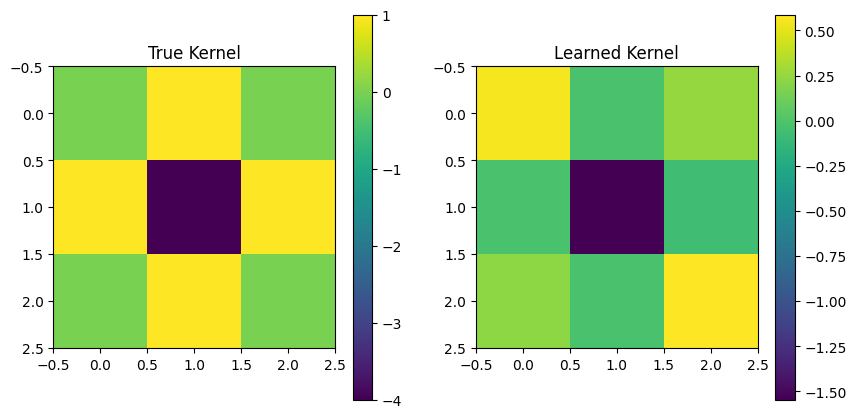

In [ ]:
# 커널 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 이미지: true_kernel
im1 = axes[0].imshow(true_kernel.reshape(3,3))
axes[0].set_title("True Kernel")
fig.colorbar(im1, ax=axes[0])  # colorbar 추가

# 두 번째 이미지: learned_kernel
im2 = axes[1].imshow(learned_kernel.reshape(3,3))
axes[1].set_title("Learned Kernel")
fig.colorbar(im2, ax=axes[1])  #  colorbar 추가

# 그래프 표시
plt.show()

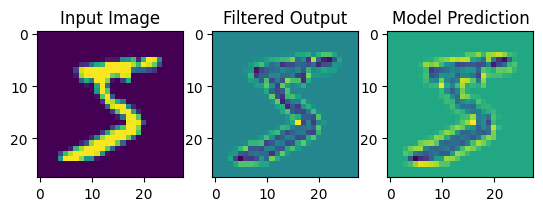

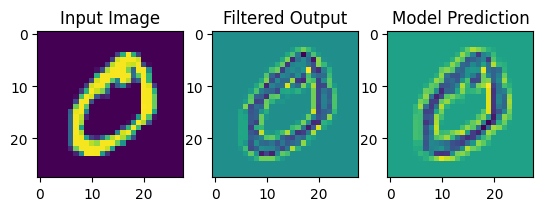

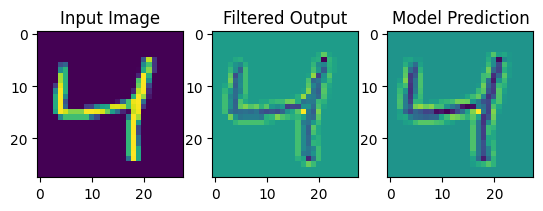

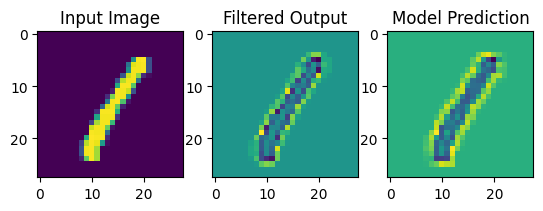

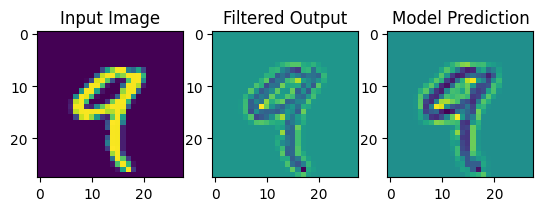

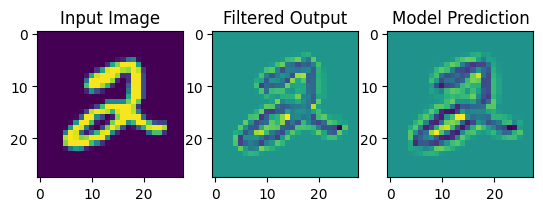

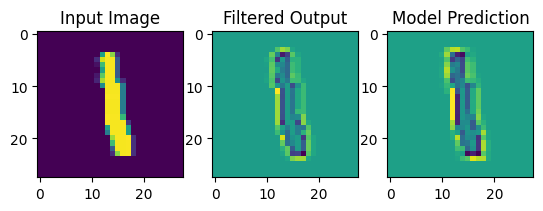

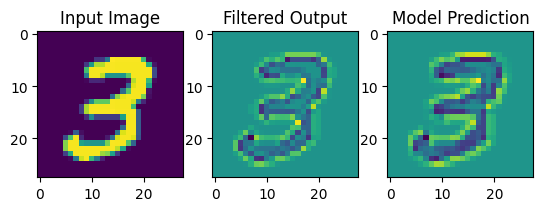

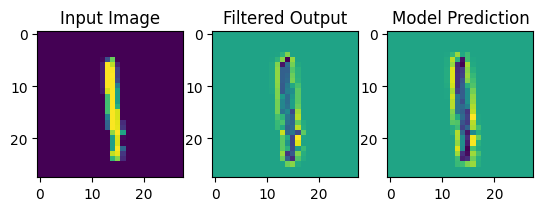

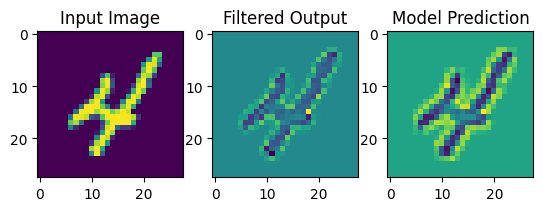

In [ ]:
# 두가지 필터를 사용한 출력 결과 비교하기

for idx in range(10):

  # 입력 데이터
  plt.subplot(1, 3, 1)
  plt.imshow(X_train[idx])
  plt.title("Input Image")

  # 필터 적용된 이미지
  plt.subplot(1, 3, 2)
  plt.imshow(Y_train[idx])
  plt.title("Filtered Output")

  # 모델의 예측 결과 (X_train[0]을 모델에 통과시킨 결과)
  predicted_output = model(X_train[idx].reshape((1, 28, 28, 1))).numpy()
  plt.subplot(1, 3, 3)
  plt.imshow(predicted_output.reshape(28, 28))
  plt.title("Model Prediction")
  plt.show()

In [ ]:
!jupyter nbconvert --to html "Lab02.ipynb"

[NbConvertApp] Converting notebook Lab02.ipynb to html
[NbConvertApp] Writing 1321866 bytes to Lab02.html
